# Credit Card Default

## Problem Statement

A key question for many financial institutions is whether an individual or entity will default on a loan. This important question can have wide implications, not just for a single institution, but also for economies as a whole.

This project will look at predicting the probability of default using machine learning methods. 

In [404]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector   
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE

In [405]:
# Program Parameters
rand_state = 0             # Random Seed to ensure reproducibility
sample_frac = .1           # Fraction of data frame for stratified sample (ease development time)
read_models = False         # Should models be read from disk or fit
save_models = True          # Should the models used be save to disk
include_pairplot = False     # Should pairplots be generated
max_iter = 10_000          # Maximum iterations for Stochastic Gradient Descent Convergence

## Data Cleaning

In [406]:
# Import the raw data set and recode names
name_dict = {'ID':'id',
             'Default':'default',
             'Prct_uso_tc':'pct_cc_usage',
             'Edad':'age',
             'Nro_prestao_retrasados':'num_loans_delayed',
             'Prct_deuda_vs_ingresos':'debt_to_income_ratio',
             'Mto_ingreso_mensual':'mthly_inc_amount',
             'Nro_prod_financieros_deuda':'num_loans_and_cc',
             'Nro_retraso_60dias':'num_late_payments',
             'Nro_creditos_hipotecarios':'num_mtg_loans',
             'Nro_retraso_ultm3anios':'pymt_delays',
             'Nro_dependiente':'num_dependents'}

dtype_dict = {'id':'object',
              'default':'bool',
              'pct_cc_usage':'float64',
              'age':'int64',
              'num_loans_delayed':'int64',
              'debt_to_income_ratio':'float64',
              'mthly_inc_amount':'float64',
              'num_loans_and_cc':'int64',
              'num_late_payments':'int64',
              'num_mtg_loans':'int64',
              'pymt_delays':'int64'}

raw_data = (pd.read_csv('data/credit_scoring.csv')
              .rename(columns=name_dict)
              .astype(dtype_dict))

raw_data.dtypes

id                       object
default                    bool
pct_cc_usage            float64
age                       int64
num_loans_delayed         int64
debt_to_income_ratio    float64
mthly_inc_amount        float64
num_loans_and_cc          int64
num_late_payments         int64
num_mtg_loans             int64
pymt_delays               int64
num_dependents          float64
dtype: object

### Stratified Sampling

In [407]:
# This code does a stratified sampling by the target class. This is done only for 
# efficiency purposes in development. For a full production run this should be set
# to 1, so all data is included. However, be prepared as this could take hours to
# run if you are fitting all of the models.
display(raw_data['default'].value_counts())

raw_data = (raw_data.groupby(by=['default'])[list(raw_data.columns)]
                    .apply(lambda x: x.sample(frac = sample_frac, random_state=rand_state))
                    .reset_index(drop=True))

display(raw_data['default'].value_counts())

raw_data.head()


default
False    139974
True      10026
Name: count, dtype: int64

default
False    13997
True      1003
Name: count, dtype: int64

,id,default,pct_cc_usage,age,num_loans_delayed,debt_to_income_ratio,mthly_inc_amount,num_loans_and_cc,num_late_payments,num_mtg_loans,pymt_delays,num_dependents
0,92967,False,0.004900,73,0,0.491189,3120.0,5,0,1,0,0.0
1,126140,False,1.000000,42,0,536.000000,NaN,1,1,0,0,0.0
2,125434,False,0.702353,28,0,0.526746,6000.0,6,0,1,0,1.0
3,29063,False,0.766658,54,0,3019.000000,NaN,4,0,1,0,0.0
4,35748,False,0.038827,50,0,0.575043,2331.0,3,0,1,0,0.0


### Investigate Missing Values

In [408]:
# Calculate the % null by column
display(raw_data.shape)
(raw_data.isnull().sum()/raw_data.shape[0])*100

(15000, 12)

id                       0.00
default                  0.00
pct_cc_usage             0.00
age                      0.00
num_loans_delayed        0.00
debt_to_income_ratio     0.00
mthly_inc_amount        20.28
num_loans_and_cc         0.00
num_late_payments        0.00
num_mtg_loans            0.00
pymt_delays              0.00
num_dependents           2.56
dtype: float64

In [409]:
# Impute the missing data using KNN
# Note: This can take several minutes
imputer = KNNImputer(weights='uniform').set_output(transform='pandas')
imp_data = imputer.fit_transform(raw_data)

# Check the imputed data for missing values
(imp_data.isnull().sum()/imp_data.shape[0])*100

id                      0.0
default                 0.0
pct_cc_usage            0.0
age                     0.0
num_loans_delayed       0.0
debt_to_income_ratio    0.0
mthly_inc_amount        0.0
num_loans_and_cc        0.0
num_late_payments       0.0
num_mtg_loans           0.0
pymt_delays             0.0
num_dependents          0.0
dtype: float64

### Drop any duplicates

In [410]:
# Drop any duplicates showing data shape before and after
display(imp_data.shape)
imp_data = imp_data.drop_duplicates()
display(imp_data.shape)

(15000, 12)

(15000, 12)

### Check Data Types

In [411]:
# Verify data types
imp_data.dtypes

id                      float64
default                 float64
pct_cc_usage            float64
age                     float64
num_loans_delayed       float64
debt_to_income_ratio    float64
mthly_inc_amount        float64
num_loans_and_cc        float64
num_late_payments       float64
num_mtg_loans           float64
pymt_delays             float64
num_dependents          float64
dtype: object

## Data Exploration

### Investigate the Target Variable

Text(0, 0.5, 'Count')

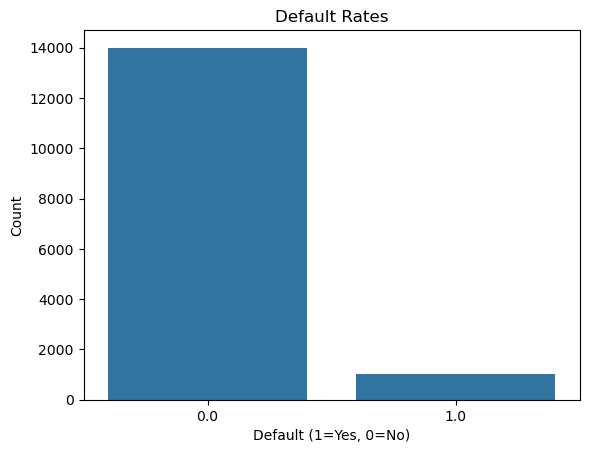

In [412]:
# Plot target feature counts
ax = sns.countplot(imp_data, x='default')
ax.set_title('Default Rates')
ax.set_xlabel('Default (1=Yes, 0=No)')
ax.set_ylabel('Count')


In [413]:
# Calculate the default rate
default_rate = imp_data['default'].mean()
print(f'Default Rate: {default_rate:.1%}')

Default Rate: 6.7%


### Investigate Correlations

Text(0.5, 1.0, 'Correlation Plot')

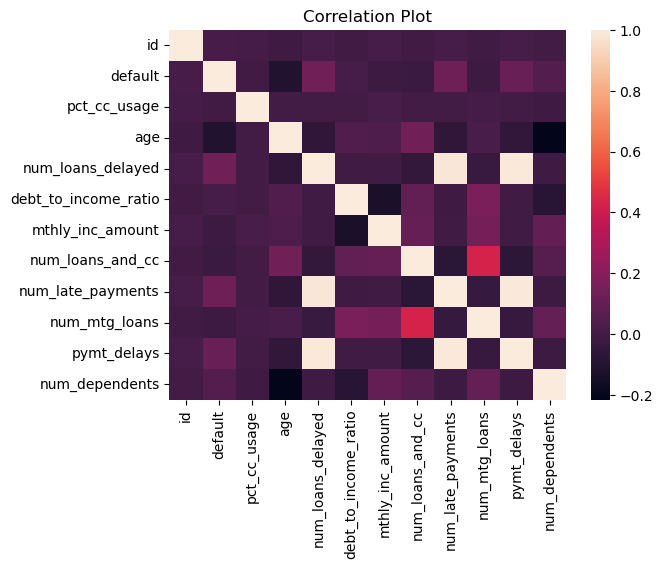

In [414]:
corr = imp_data.corr()
ax = sns.heatmap(corr)
ax.set_title("Correlation Plot")

### Explore and Treat Outliers

Text(0.5, 0.98, 'Distributions by Default')

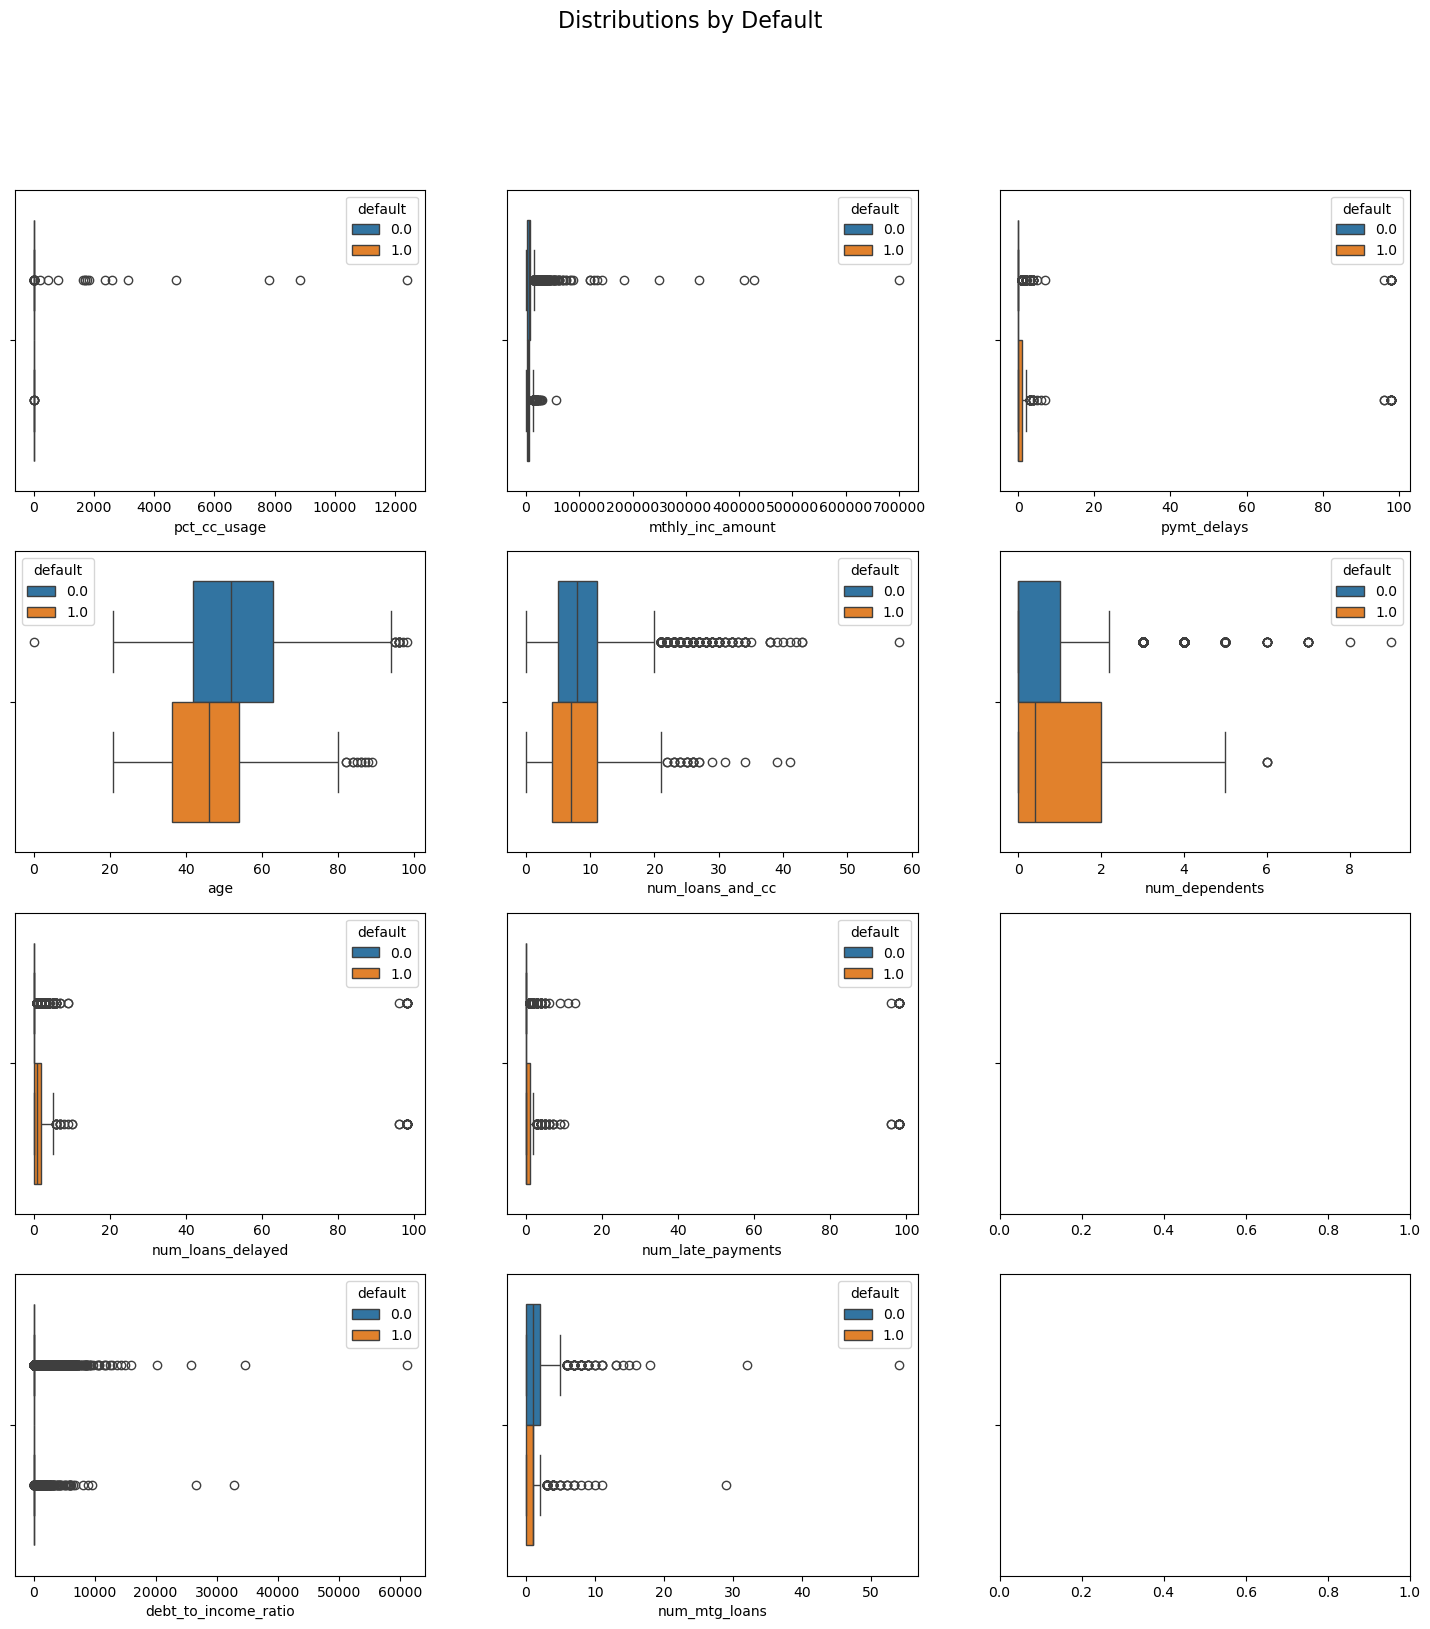

In [415]:
# Look at explanatory feature distributions by the target levels
def dist_charts(data):
    fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(18,18), sharey=True)
    sns.boxplot(data, x='pct_cc_usage', hue='default', ax=axs[0,0])
    sns.boxplot(data, x='age', hue='default', ax=axs[1,0])
    sns.boxplot(data, x='num_loans_delayed', hue='default', ax=axs[2,0])
    sns.boxplot(data, x='debt_to_income_ratio', hue='default', ax=axs[3,0])
    
    sns.boxplot(data, x='mthly_inc_amount', hue='default', ax=axs[0,1])
    sns.boxplot(data, x='num_loans_and_cc', hue='default', ax=axs[1,1])
    sns.boxplot(data, x='num_late_payments', hue='default', ax=axs[2,1])
    sns.boxplot(data, x='num_mtg_loans', hue='default', ax=axs[3,1])
    
    sns.boxplot(data, x='pymt_delays', hue='default', ax=axs[0,2])
    sns.boxplot(data, x='num_dependents', hue='default', ax=axs[1,2])
    return((fig, axs))
    
fig, axs = dist_charts(imp_data)
fig.suptitle('Distributions by Default', fontsize=16)

In [416]:
# Examine a pairplot
# This can take about 30 minutes to run
if include_pairplot == True:
    sns.pairplot(imp_data, hue='default')

In [417]:
# Examine Outliers
clf = IsolationForest(random_state=0).fit(imp_data)
imp_data['outlier_score'] = clf.predict(imp_data)
imp_data['outlier_score'].value_counts()

imp_data.columns

Index(['id', 'default', 'pct_cc_usage', 'age', 'num_loans_delayed',
       'debt_to_income_ratio', 'mthly_inc_amount', 'num_loans_and_cc',
       'num_late_payments', 'num_mtg_loans', 'pymt_delays', 'num_dependents',
       'outlier_score'],
      dtype='object')

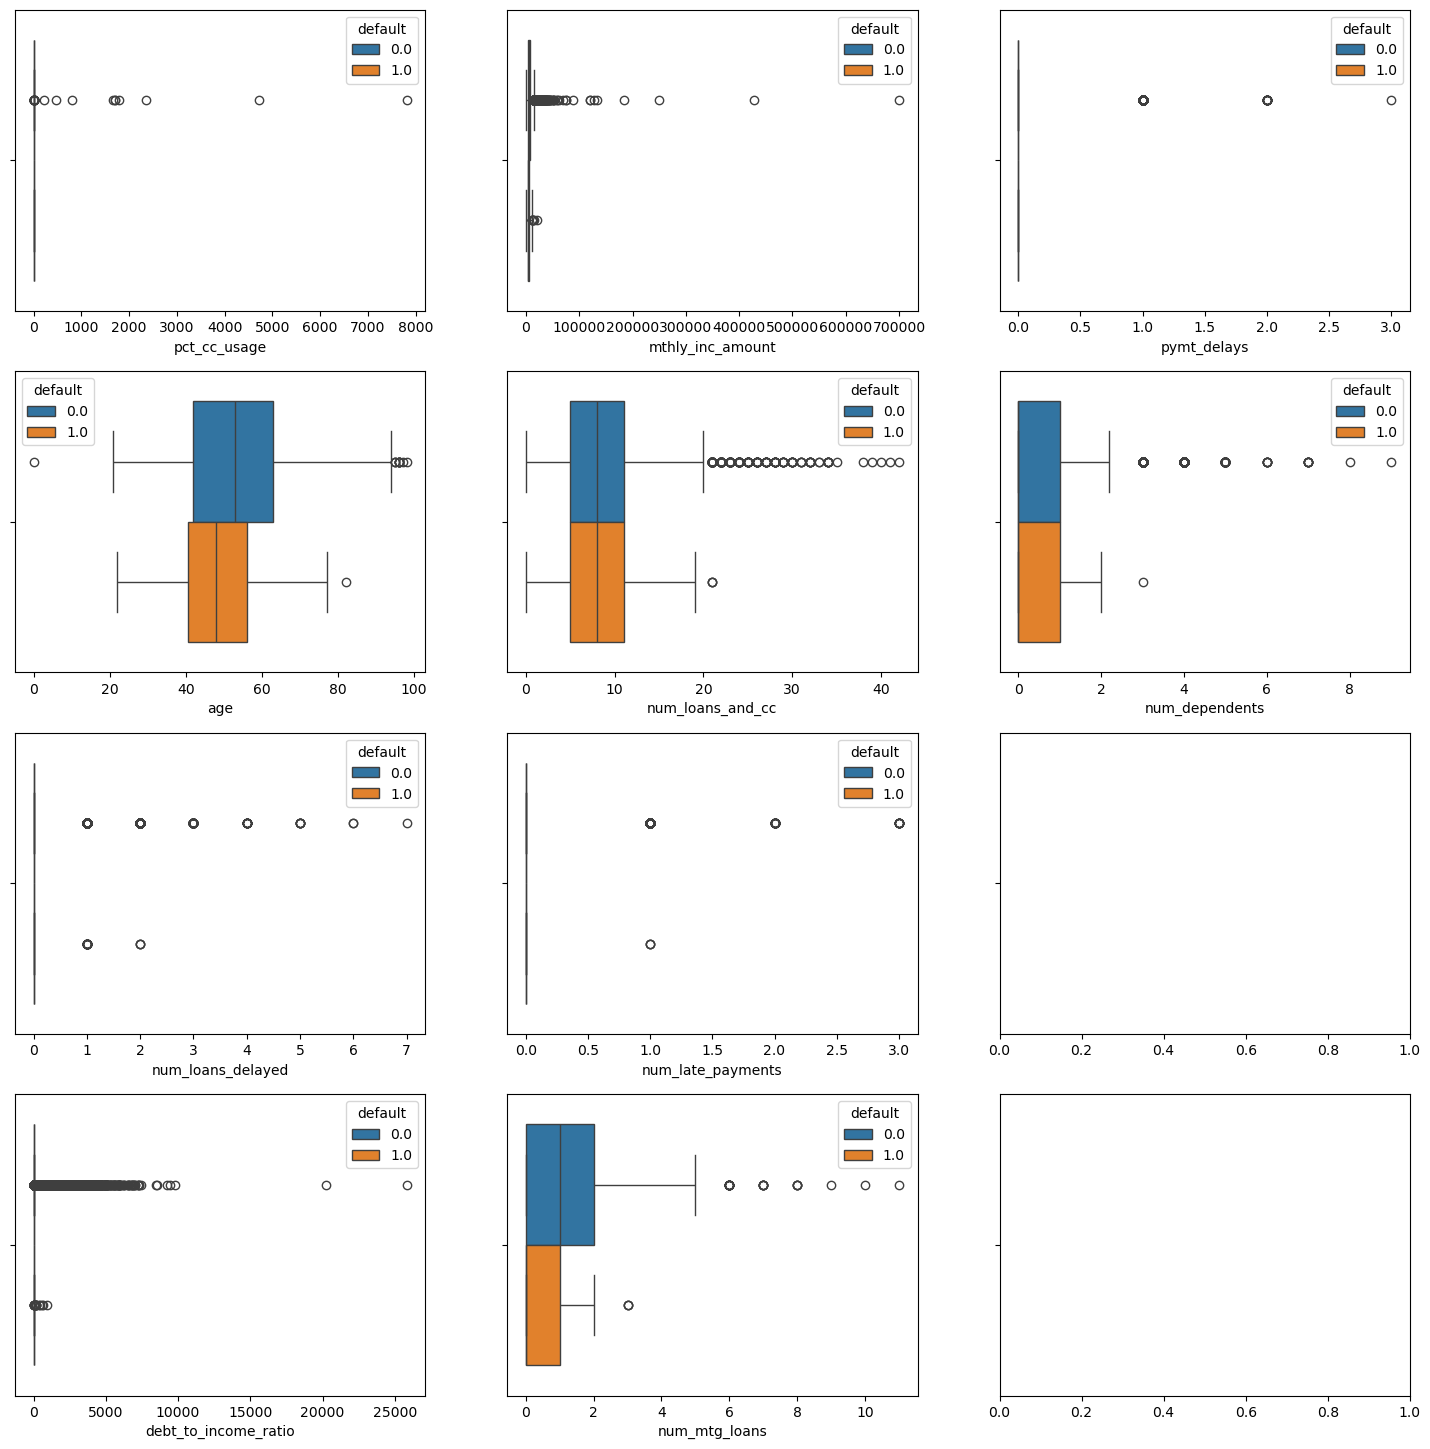

In [418]:
fig, axs = dist_charts(imp_data.query('outlier_score == 1'))

In [419]:
imp_data.columns

Index(['id', 'default', 'pct_cc_usage', 'age', 'num_loans_delayed',
       'debt_to_income_ratio', 'mthly_inc_amount', 'num_loans_and_cc',
       'num_late_payments', 'num_mtg_loans', 'pymt_delays', 'num_dependents',
       'outlier_score'],
      dtype='object')

In [420]:
# Remove outliers and pairplot
imp_no_data = imp_data.query('outlier_score == 1')

if include_pairplot == True:
    sns.pairplot(imp_no_data, hue='default')

## Create Training & Testing Datasets

### Drop Unnecessary Columns

In [421]:
# Drop the id column
imp_data = imp_data.drop('id', axis=1)

### Create Training & Test Splits

In [422]:
# Create training and testing datasets
imp_data.columns
X, y = imp_data.drop('default', axis=1), imp_data['default']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Extract base feature names to list for later use
base_feature_names = list(X.columns)
target_feature_name = y.name

### Create Resampling Training Sets

In [423]:
# Use SMOTE to resample the minority class
sm = SMOTE(random_state = rand_state)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)
y_train_balanced.value_counts()


/home/jonathan/miniforge3/envs/cc_default/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jonathan/miniforge3/envs/cc_default/lib/python3.13/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


default
0.0    10495
1.0    10495
Name: count, dtype: int64

## Data Preprocessing


### Feature Engineering

## Model Building

### Baseline Model (Dummy Classifier)

In [424]:
# Create a baseline/naive model
if read_models == False:
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_train, y_train)
else:
    dummy_clf = joblib.load('models/dummy_classifier.pkl')
    
# Conditionally save the classifier
if save_models == True:
    joblib.dump(dummy_clf, 'models/dummy_classifier.pkl')
    
# Print the classification reports
print('Training Set Classification Report - Baseline *******')
print(classification_report(y_train, dummy_clf.predict(X_train)))
print('Testing Set Classification Report - Baseline ********')
print(classification_report(y_test, dummy_clf.predict(X_test)))

# Extract classification reports
dummy_train_rpt = classification_report(y_train, dummy_clf.predict(X_train), output_dict=True)
dummy_test_rpt = classification_report(y_test, dummy_clf.predict(X_test), output_dict=True)

Training Set Classification Report - Baseline *******
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97     10495
         1.0       0.00      0.00      0.00       755

    accuracy                           0.93     11250
   macro avg       0.47      0.50      0.48     11250
weighted avg       0.87      0.93      0.90     11250

Testing Set Classification Report - Baseline ********
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97      3502
         1.0       0.00      0.00      0.00       248

    accuracy                           0.93      3750
   macro avg       0.47      0.50      0.48      3750
weighted avg       0.87      0.93      0.90      3750



/home/jonathan/miniforge3/envs/cc_default/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/miniforge3/envs/cc_default/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jonathan/miniforge3/envs/cc_default/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Text(0.5, 0.98, 'Baseline Confusion Matrix')

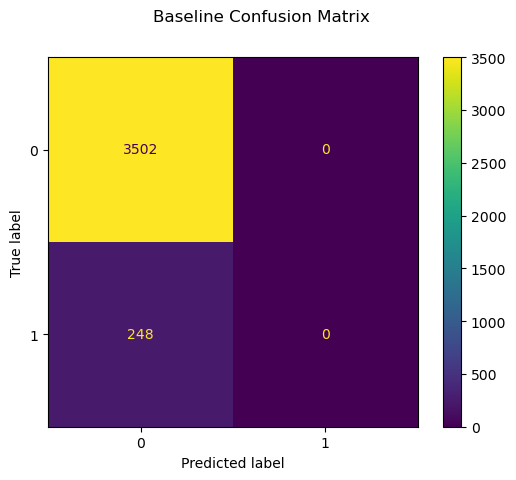

In [425]:
# Plot the confusion matrix
dummy_cm = confusion_matrix(y_test, dummy_clf.predict(X_test))
ConfusionMatrixDisplay(dummy_cm).plot()
plt.suptitle('Baseline Confusion Matrix')

### Logistic Regression

#### Model or Load Logistic Regression Pipeline

In [426]:
# Load or fit model
if read_models == False:
    lr_pipe = Pipeline([
        ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
        ('standard_scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(SGDClassifier(loss='log_loss', n_jobs=-1), 
                                               n_features_to_select=6,
                                               n_jobs=-1)),
        ('logistic_regression', SGDClassifier(loss='log_loss', n_jobs=-1,
                                              max_iter=max_iter))
    ])

    lr_pipe.fit(X_train_balanced, y_train_balanced)

else:
    lr_pipe = joblib.load('models/logistic_regression_pipe.pkl')

# Conditionally save the model
if save_models == True:
    joblib.dump(lr_pipe, 'models/logistic_regression_pipe.pkl')

# Print the classification reports
print('Training Set Classification Report - Logistic Reg. **')
print(classification_report(y_train, lr_pipe.predict(X_train)))

# Extract classification reports
lr_train_rpt = classification_report(y_train, lr_pipe.predict(X_train), output_dict=True)
lr_test_rpt = classification_report(y_test, lr_pipe.predict(X_test), output_dict=True)


Training Set Classification Report - Logistic Reg. **
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     10495
         1.0       0.63      0.80      0.71       755

    accuracy                           0.96     11250
   macro avg       0.81      0.88      0.84     11250
weighted avg       0.96      0.96      0.96     11250



Text(0.5, 0.98, 'Logistic Regression Confusion Matrix')

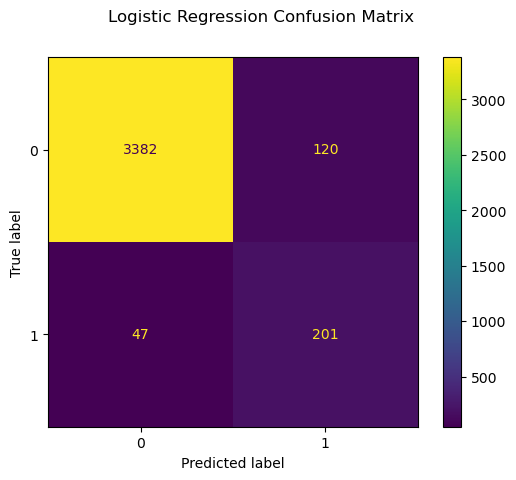

In [427]:
# Plot the confusion matrix
lr_cm = confusion_matrix(y_test, lr_pipe.predict(X_test))
ConfusionMatrixDisplay(lr_cm).plot()
plt.suptitle('Logistic Regression Confusion Matrix')

### Decision Tree

In [428]:
# Implement a decision tree using gridCV
if read_models == False:
    # Parameters for the GridSearch
    params = {'min_impurity_decrease': [0.001, 0.01, 0.02, 0.03, 0.05],
              'max_depth': [2, 5, 10],
              'min_samples_split': [0.1, 0.2, 0.05],
              'criterion': ['gini', 'entropy']}

    dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=rand_state),
                           param_grid=params,
                           scoring='recall').fit(X_train_balanced, y_train_balanced)
else:
    dt_grid = joblib.load('models/decision_tree_grid_search.pkl')
    
if save_models == True:
    joblib.dump(dt_grid, 'models/decision_tree_grid_search.pkl')

display(dt_grid.best_params_)

# Print the classification reports
print('Training Set Classification Report - Decision Tree **')
print(classification_report(y_train, dt_grid.predict(X_train)))
print('Testing Set Classification Report - Decision Tree ***')
print(classification_report(y_test, dt_grid.predict(X_test)))

# Extract classification reports
dt_train_rpt = classification_report(y_train, dt_grid.predict(X_train), output_dict=True)
dt_test_rpt = classification_report(y_test, dt_grid.predict(X_test), output_dict=True)

{'criterion': 'entropy',
 'max_depth': 10,
 'min_impurity_decrease': 0.001,
 'min_samples_split': 0.1}

Training Set Classification Report - Decision Tree **
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     10495
         1.0       0.58      0.80      0.67       755

    accuracy                           0.95     11250
   macro avg       0.78      0.88      0.82     11250
weighted avg       0.96      0.95      0.95     11250

Testing Set Classification Report - Decision Tree ***
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      3502
         1.0       0.57      0.82      0.67       248

    accuracy                           0.95      3750
   macro avg       0.78      0.89      0.82      3750
weighted avg       0.96      0.95      0.95      3750



Text(0.5, 0.98, 'Decision Tree Confusion Matrix')

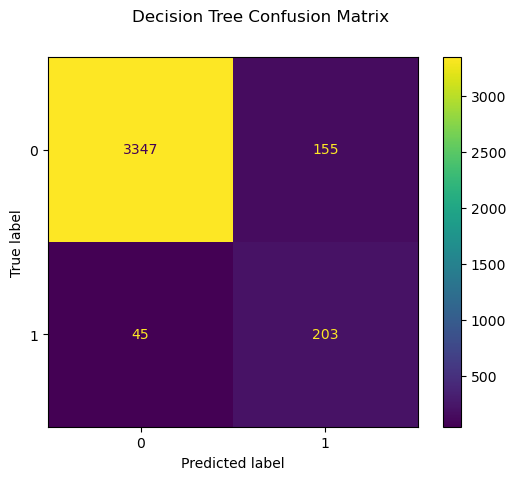

In [429]:
# Plot the confusion matrix
dt_cm = confusion_matrix(y_test, dt_grid.predict(X_test))
ConfusionMatrixDisplay(dt_cm).plot()
plt.suptitle('Decision Tree Confusion Matrix')

### Random Forest

In [430]:
if read_models == False:
    rf_clf = RandomForestClassifier(**dt_grid.best_params_).fit(X_train_balanced, y_train_balanced)
else:
    rf_clf = joblib.load('models/random_forest_classifier.pkl')
    
if save_models == True:
    joblib.dump(rf_clf, 'models/random_forest_classifier.pkl')

# Print the classification reports
print('Training Set Classification Report - Random Forest **')
print(classification_report(y_train, rf_clf.predict(X_train)))
print('Testing Set Classification Report - Random Forest ***')
print(classification_report(y_test, rf_clf.predict(X_test)))

# Extract classification reports
rf_train_rpt = classification_report(y_train, rf_clf.predict(X_train), output_dict=True)
rf_test_rpt = classification_report(y_test, rf_clf.predict(X_test), output_dict=True) 

Training Set Classification Report - Random Forest **
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     10495
         1.0       0.59      0.80      0.68       755

    accuracy                           0.95     11250
   macro avg       0.79      0.88      0.83     11250
weighted avg       0.96      0.95      0.95     11250

Testing Set Classification Report - Random Forest ***
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      3502
         1.0       0.58      0.82      0.68       248

    accuracy                           0.95      3750
   macro avg       0.79      0.89      0.83      3750
weighted avg       0.96      0.95      0.95      3750



Text(0.5, 0.98, 'Random Forest Confusion Matrix')

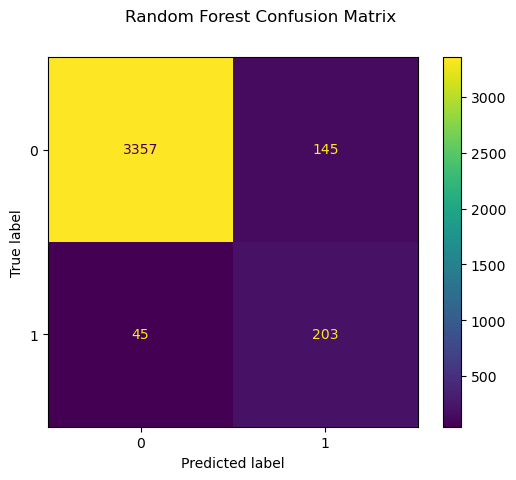

In [431]:
# Plot the confusion matrix
rf_cm = confusion_matrix(y_test, rf_clf.predict(X_test))
ConfusionMatrixDisplay(rf_cm).plot()
plt.suptitle('Random Forest Confusion Matrix')

## Evaluation

## Business Conclusions

## References

## Questions
- Should I sample for a decision tree or random forest model?
- I believe that I want to maximize the Recall (true positive rate)
- How should I eliminate the convergence errors